In [1]:
%pylab inline
from astropy import units
import astropy as apy
from profiles import *
from math import erf
from cosmotools import *

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
print dens_NFW(11, 10, 0, 0, 1E12)
print rvir2(1E12, 0)
print rvir(1E12, 0)

1.56823998312
4481226.61354 solMass / kpc3
260.15450448 kpc
261.24380107 kpc


In [2]:
v_i = vc_NFW(11, 10, 0, 0, 1E12)
print v_i
print v_i.to(units.kpc/units.Gyr)

153.351428061 km / s
156.834371006 kpc / Gyr


In [4]:
def coulomb_log(r):
    bmax = r # position of test particle at a time t
    k = 1.42 * units.kpc # kpc
    bmin = 1.4 * k # k is the softening length if the LMC were modeled using a plummer progile . See Besla07
    L = bmax / bmin
    return np.log(L)

def sigma(c, r, M_halo):
    M_halo = M_halo * units.Msun
    Rvir = rvir(M_halo.value, 0) 
    vvir = np.sqrt( G * M_halo / Rvir) 
    g = log(1+c) - (c /(1+c))
    vmax = np.sqrt(0.216 * vvir**2 * c / g)
    rs = Rvir / c
    x = r / rs
    sigma = vmax * 1.4393 * x **(0.354) / (1 + 1.1756*x**0.725)
    sigma = sigma.to(units.kpc / units.Gyr)
    return sigma

sigma(11, 10 * units.kpc, 1E12)

def dynamical_friction_sis(x, y, z, vx, vy, vz, M_sat):
    # Coordinates
    x = x * units.kpc
    y = y * units.kpc
    z = z * units.kpc
    r = np.sqrt(x**2 + y**2 + z**2)
    # Velocities
    vx = vx * units.kpc / units.Gyr
    vy = vy * units.kpc / units.Gyr
    vz = vz * units.kpc / units.Gyr
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # Density of the NFW at a given r
    rho = dens_NFW(11, x.value, y.value, z.value, 1E12) # a, r, v  ****
    # Mass of the satellite
    M_sat = M_sat * units.Msun
    # Computing the dyanmical friction
    factor = 4 * np.pi * G**2
    Coulomb = 3# coulomb_log(r)
    s = sigma(11, r, 1E12) #       ****
    X = v / ( np.sqrt(2) * s ) 
    # Main equation
    a_dfx = factor * M_sat * rho * Coulomb / v**3 * (  erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))  ) * vx
    a_dfy = factor * M_sat * rho * Coulomb / v**3 * (  erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))  ) * vy
    a_dfz = factor * M_sat * rho * Coulomb / v**3 * (  erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))  ) * vz
    # Transforming to the right units
    a_dfx = a_dfx.to(units.kpc / units.Gyr**2)
    a_dfy = a_dfy.to(units.kpc / units.Gyr**2)
    a_dfz = a_dfz.to(units.kpc / units.Gyr**2)
    tt = factor * M_sat * rho * Coulomb 
    print tt.to(units.kpc**3/units.Gyr**4)
    print rho
    #print erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))
    #print vy/v**3
    return a_dfx.value, a_dfy.value, a_dfz.value


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


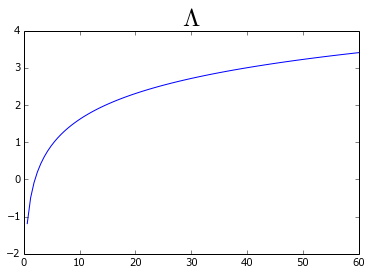

In [4]:
r = linspace(0, 60, 100) * units.kpc
plot(r, coulomb_log(r))
title("$\Lambda$", fontsize=25)

In [5]:
print sigma(11, r, 1E12)[1]
#plot(r, sigma(11, r, 1E12)[0])
#xlabel("$r(Kpc)$", fontsize=25)
#ylabel("$\sigma(Kpc/Gyr)$", fontsize=25)

46.3913944742 kpc / Gyr


In [6]:
print dynamical_friction_sis(10, 0, 0, 0, 153.35, 0, 1E11)
#print dens_NFW(11, 40, 0, 0, 1E12)  

337654249.609 kpc3 / Gyr4
4423476.13206 solMass / kpc3
(-0.0, -101433.16583119385, -0.0)


In [193]:
def acceleration(x, y, z, vx, vy, vz):
    #M_bulge = 1E10
    #M_disk = 5.5E10
    M_halo = 1E12
    M_sat = 1E11
    #asis = a_sis(10, x, y, z, 200)
    #adisk = a_mn(6.5, 0.6, x, y, z, M_disk)
    ahalo = a_NFW(11.0, x, y, z, M_halo)
    #print abulge, adisk, ahalo
    ax = ahalo[0] #+ adisk[0] + ahalo[0]
    ay = ahalo[1] #+ adisk[1] + ahalo[1]
    az = ahalo[2] #+ adisk[2] + ahalo[2]
    ax = ax.to(units.kpc/units.Gyr**2)  
    ay = ay.to(units.kpc/units.Gyr**2) 
    az = az.to(units.kpc/units.Gyr**2) 
    a_dfx, a_dfy, a_dfz = dynamical_friction_sis(x, y, z, vx, vy, vz, M_sat)
    Ax = ax.value + a_dfx
    Ay = ay.value + a_dfy
    Az = az.value + a_dfz
    return Ax, Ay, Az

In [194]:
acceleration(10, 0, 0, 0, 150, 0)

(-2459.7019928968857, -80387.45833776054, -0.0)

In [195]:
def leapfrog(n_points, h, x_ic, y_ic, z_ic, vx_ic, vy_ic, vz_ic):

        #n_points = 3000
        #h = 0.001
        # Creating the arrays to collect the data in each step of the integration
        # the imput units should be in Kpc and Gyrs!

        t = np.zeros(n_points)
        x = np.zeros(n_points)
        y = np.zeros(n_points)
        z = np.zeros(n_points)

        vx = np.zeros(n_points)
        vy = np.zeros(n_points)
        vz = np.zeros(n_points)


        ax = np.zeros(n_points)
        ay = np.zeros(n_points)
        az = np.zeros(n_points)

        t[0] = 0

        # This initial conditions come form MW.py, the units are Kpc and Gyr
        x[0] = x_ic
        y[0] = y_ic
        z[0] = z_ic


        vx[0] = vx_ic
        vy[0] = vy_ic
        vz[0] = vz_ic

        ax[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[0]
        ay[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[1]
        az[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[2]

        # one half step 

        t[1] = t[0] + h
        x[1] = x[0] + h * vx[0]
        y[1] = y[0] + h * vy[0]
        z[1] = z[0] + h * vz[0]

        vx[1] = vx[0] + h*acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[0]
        vy[1] = vy[0] + h*acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[1]
        vz[1] = vz[0] + h*acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[2]

        ax[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[0]
        ay[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[1]
        az[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[2]

        # iterate over all the steps!

        for i in range(2,n_points):
            t[i] = t[i-1] + h

            x[i] = x[i-2] + 2 * h * vx[i-1]
            y[i] = y[i-2] + 2 * h * vy[i-1]
            z[i] = z[i-2] + 2 * h * vz[i-1]

            vx[i] = vx[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[0]
            vy[i] = vy[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[1]
            vz[i] = vz[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[2]
        
        return x, y, z, t, ax, ay, az 

In [201]:
X, Y, Z, t, ax, ay, az = leapfrog(100, 0.001, 10, 0, 0, 0, 156.834371006, 0)

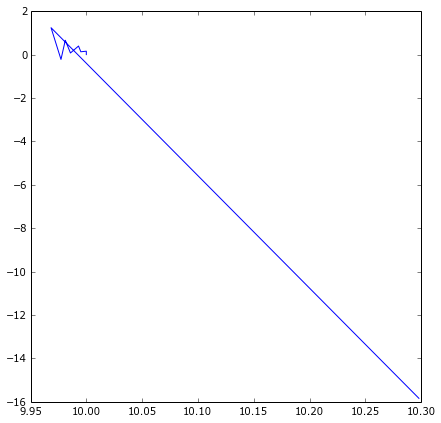

In [202]:
figure(figsize=(7, 7))

plot(X, Y)
#xlim(-15, 15)
#ylim(-15, 15)

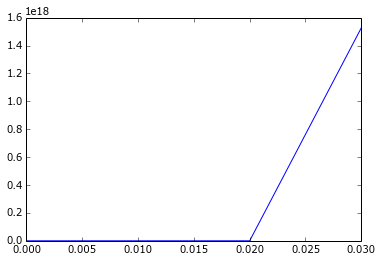

In [198]:
plot(t, np.sqrt(X**2+Y**2+Z**2))

In [199]:
print t

[ 0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59
  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71
  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83
  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95
  0.96  0.97  0.98  0.99  1.    1.01  1.02  1.03  1.04  1.05  1.06  1.07
  1.08  1.09  1.1   1.11  1.12  1.13  1.14  1.15  1.16  1.17  1.18  1.19
  1.2   1.21  1.22  1.23  1.24  1.25  1.26  1.27  1.28  1.29  1.3   1.31
  1.32  1.33  1.34  1.35  1.36  1.37  1.38  1.39  1.4   1.41  1.42  1.43
  1.44  1.45  1.46  1.47  1.48  1.49  1.5   1.51  1.52  1.53  1.54  1.55
  1.56  1.57  1.58  1.59  1.6   1.61  1.62  1.63  1

In [178]:
print ax, ay, az

[-2459.7019929  -2418.01023777     0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
    